In [8]:
#*****************************************Import********************************************
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import time

df=pd.read_csv("dataset/PhishingDataset.csv")

ROWS = len(df.axes[0]) 
COLUMNS = len(df.axes[1])
df = df.replace([np.inf, -np.inf], np.nan)
df=df.dropna()
LABEL = df.iloc[:,-1:].columns[0]


print("Row-Column Count before cleaning: (", ROWS , " , ",  COLUMNS , ")")

df.iloc[:,-1:].value_counts()

Row-Column Count before cleaning: ( 235795  ,  56 )


label
1        134850
0        100945
Name: count, dtype: int64

In [9]:
#cols = df.select_dtypes(include=['float64','int64']).columns
#dfAll = pd.DataFrame(df['FILENAME']).copy()
#df = pd.DataFrame(df[cols]).copy()
df = df.reset_index(drop=True)
LABEL = df.iloc[:,-1:].columns[0]
cols = ['LineOfCode', 'NoOfExternalRef', 'LargestLineLength', 'URLLength', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'NoOfCSS', 
        'URLCharProb', 'CharContinuationRate', 'LetterRatioInURL', 'IsHTTPS', 'SpacialCharRatioInURL','NoOfEmptyRef', 
        'NoOfOtherSpecialCharsInURL', 'HasDescription', 'HasSocialNet', 'DomainLength', 'DegitRatioInURL','NoOfDegitsInURL',
        'HasCopyrightInfo', 'NoOfLettersInURL','TLDLegitimateProb', 'DomainTitleMatchScore', 'IsResponsive', 
        'HasHiddenFields', 'HasSubmitButton','NoOfSubDomain', 'HasFavicon', 'HasTitle',LABEL]
df = pd.DataFrame(df[cols]).copy()
df30, df70=train_test_split(df,test_size=.1)

df30 = df30.reset_index(drop=True)
df70 = df70.reset_index(drop=True)

yTrain = pd.DataFrame(df30[LABEL]).copy()
df30.drop(LABEL, axis=1, inplace=True)
xTrain = pd.DataFrame(df30).copy()

dfX = pd.DataFrame(df70[cols]).copy()
dfX.drop(LABEL, axis=1, inplace=True)
dfY = pd.DataFrame(df70[LABEL]).copy()
print("Finished Train-Test Split.")
len(xTrain.axes[0]) 

Finished Train-Test Split.


212215

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
Models = []
Models.append(("BernoulliNB",BernoulliNB(alpha= 0.01, binarize= 0.0, class_prior= None, fit_prior= False, force_alpha= True)))
Models.append(("PassiveAggressive",PassiveAggressiveClassifier(C= 4, fit_intercept= False, n_iter_no_change= 50, n_jobs= 10, shuffle= True, verbose= 0)))
Models.append(("SGDClassifier",SGDClassifier(alpha= 0.01, eta0= 100, n_iter_no_change= 50, n_jobs= 1)))

start = time.time()
for name, model in Models:
    model.fit(xTrain, yTrain)
end = time.time()
OneTime = int(end - start)
print("Finished first training: ", OneTime)

Finished first training:  24


In [11]:
Handler = pd.DataFrame(columns=['BernoulliNB','PassiveAggressive','SGDClassifier', 'sum','isCorrect','predicted',
                                'label','LowSecurity','BestSecurity','HighSecurity','LearningRate','AverageLearningRate'])
LRList = []
AvgLRList = []
n = len(dfX.axes[0])
X = dfX.iloc[[0]].to_numpy() 
Y = dfY.iloc[[0]]
Y = np.array(Y[LABEL])
p = len(Models)    
accurate=0
start = time.time()
for i in range(0,n):
    try:
        X = dfX.iloc[[i]].to_numpy() 
        Y = dfY.iloc[[i]]
        Y = np.array(Y[LABEL])
        predict=0
        yP=0
        nRow = {}
        nRow['isCorrect'] = 0
        nRow['LowSecurity'] = 0
        nRow['BestSecurity'] = 0
        nRow['HighSecurity'] = 0
        
        for name, model in Models:
            pr = model.predict(X)
            predict = predict + pr[0]
            model.partial_fit(X, Y, classes=[0,1])
            if(pr[0]==Y[0]):
                nRow[name] = 1
            else:
                nRow[name] = 0

        if (predict==1):
            nRow['LowSecurity'] = 1
        elif (predict==2):
            yP = 1
            nRow['LowSecurity'] = 1
            nRow['BestSecurity'] = 1
        elif (predict==3):
            yP = 1
            nRow['LowSecurity'] = 1
            nRow['BestSecurity'] = 1
            nRow['HighSecurity'] = 1
            
            
        if(yP==Y[0]):
            accurate = accurate + 1
            nRow['isCorrect'] = 1
        elif(i%250==0): 
            print(i)
        nRow['sum'] = predict
        nRow['predicted'] = yP
        nRow['label'] = Y[0]
          
        LearnRate=accurate/n
        AvgLearnRate=accurate/(i+1)
        LRList.append(LearnRate)
        AvgLRList.append(AvgLearnRate)
        
        nRow['LearningRate'] = LearnRate
        nRow['AverageLearningRate'] = AvgLearnRate

        Handler = pd.concat([Handler, pd.DataFrame([nRow])], ignore_index=True)
        
    except Exception as ex:
        print(ex)
end = time.time()
IncTime = int(end - start)
# Handler.to_csv('dataset/ReportsPhishing/Model_Result_29May_90.csv',index = False)
print('Time:', IncTime, ' Accuracy:',accurate/n)

Time: 61  Accuracy: 0.9984308736217133


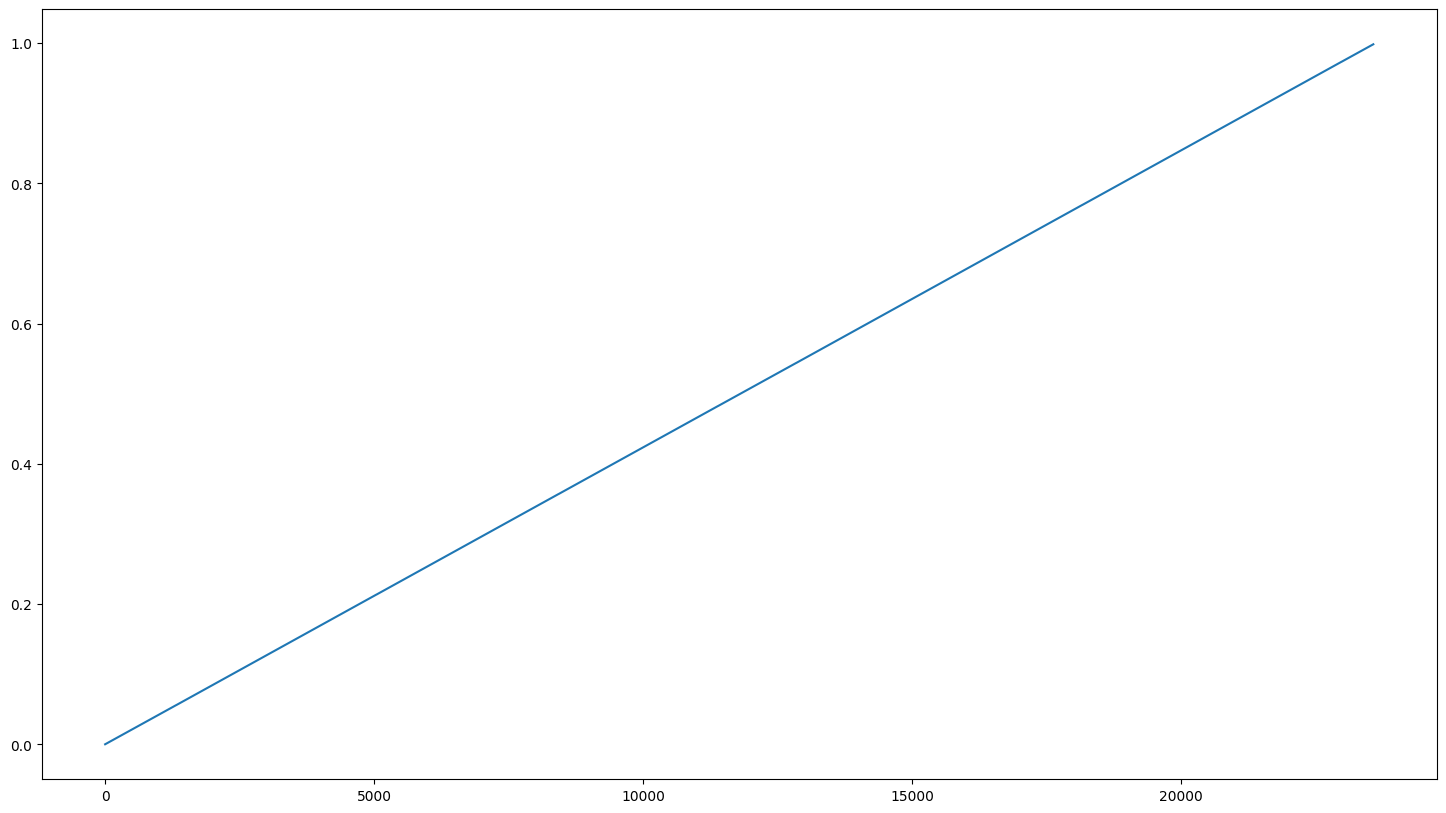

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(LRList)

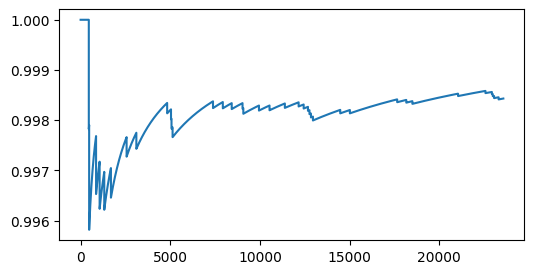

In [13]:
plt.figure(figsize=(6,3))
plt.plot(AvgLRList)

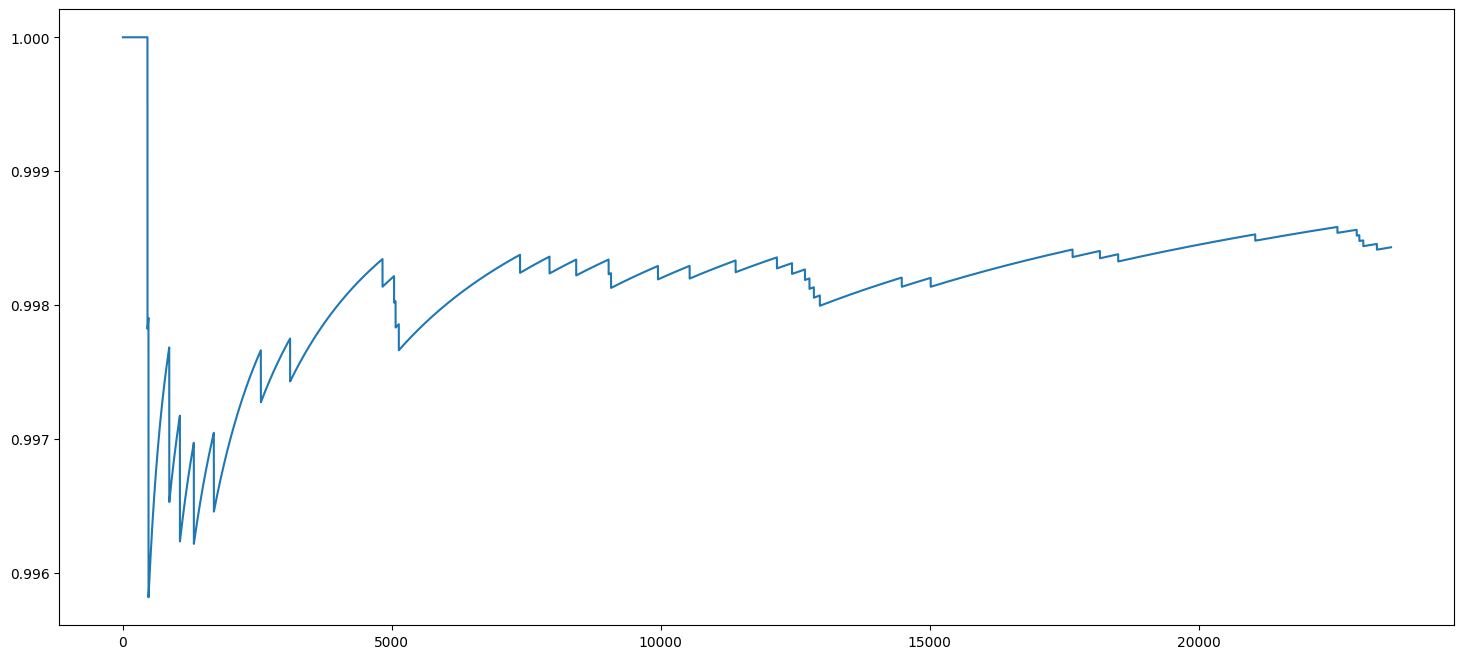

In [14]:
plt.figure(figsize=(18,8))
plt.plot(AvgLRList)

In [15]:
ResAnalysis = pd.DataFrame(columns=['yTest']).copy()
ResAnalysis['yTest'] = Handler['label']
ResAnalysis['M1Vote'] = Handler['LowSecurity']
ResAnalysis['M1rTP'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['LowSecurity']==1, 1, 0), 0)
ResAnalysis['M1rTN'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['LowSecurity']==0, 1, 0), 0)
ResAnalysis['M1rFP'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['LowSecurity']==1, 1, 0), 0)
ResAnalysis['M1rFN'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['LowSecurity']==0, 1, 0), 0)

records = len(ResAnalysis['yTest'])
CorretPred = np.where(ResAnalysis['yTest'] == ResAnalysis['M1Vote'], 1, 0).sum()
TP = int(ResAnalysis['M1rTP'].sum())
TN = int(ResAnalysis['M1rTN'].sum())
FP = int(ResAnalysis['M1rFP'].sum())
FN = int(ResAnalysis['M1rFN'].sum())
print(TP, ' ' , TN, ' ', FP,' ', FN)

MCC = int((TP*TN)-(FP*FN))/(int((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)

Accuracy = CorretPred/records
Precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
F1Score = 2* ((Precision*Sensitivity)/(Precision+Sensitivity))


print("Accuracy    : ", Accuracy)
print("Precision   : ", Precision)
print("Sensitivity : ", Sensitivity)
print("F1 Score    : ", F1Score )
print("MCC    : ", MCC )

Metrics= pd.DataFrame()
newRow = {}
newRow['Mode'] = "LowSecurity"
newRow['Accuracy'] = Accuracy
newRow['Precision'] = Precision
newRow['Sensitivity'] = Sensitivity
newRow['F1Score'] = F1Score
newRow['MCC'] = MCC
newRow['OneTime'] = OneTime
newRow['IncTime'] = IncTime
Metrics = pd.concat([Metrics, pd.DataFrame([newRow])], ignore_index=True)

CM= pd.DataFrame()
newRow = {}
newRow['Mode'] = "LowSecurity"
newRow['TP'] = TP
newRow['TN'] = TN
newRow['FP'] = FP
newRow['FN'] = FN
CM = pd.concat([CM, pd.DataFrame([newRow])], ignore_index=True)

13475   9767   337   1
Accuracy    :  0.9856658184902459
Precision   :  0.9756009267303793
Sensitivity :  0.9999257940041555
F1 Score    :  0.9876136030489593
MCC    :  0.9710253530382837


In [16]:
ResAnalysis = pd.DataFrame(columns=['yTest']).copy()
ResAnalysis['yTest'] = Handler['label']
ResAnalysis['M2Vote'] = Handler['BestSecurity']
ResAnalysis['M2rTP'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['BestSecurity']==1, 1, 0), 0)
ResAnalysis['M2rTN'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['BestSecurity']==0, 1, 0), 0)
ResAnalysis['M2rFP'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['BestSecurity']==1, 1, 0), 0)
ResAnalysis['M2rFN'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['BestSecurity']==0, 1, 0), 0)

records = len(ResAnalysis['yTest'])
CorretPred = np.where(ResAnalysis['yTest'] == ResAnalysis['M2Vote'], 1, 0).sum()
TP = int(ResAnalysis['M2rTP'].sum())
TN = int(ResAnalysis['M2rTN'].sum())
FP = int(ResAnalysis['M2rFP'].sum())
FN = int(ResAnalysis['M2rFN'].sum())
print(TP, ' ' , TN, ' ', FP,' ', FN)

MCC = int((TP*TN)-(FP*FN))/(int((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)

Accuracy = CorretPred/records
Precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
F1Score = 2* ((Precision*Sensitivity)/(Precision+Sensitivity))


print("Accuracy    : ", Accuracy)
print("Precision   : ", Precision)
print("Sensitivity : ", Sensitivity)
print("F1 Score    : ", F1Score )
print("MCC    : ", MCC )

newRow = {}
newRow['Mode'] = "BestSecurity"
newRow['Accuracy'] = Accuracy
newRow['Precision'] = Precision
newRow['Sensitivity'] = Sensitivity
newRow['F1Score'] = F1Score
newRow['MCC'] = MCC
newRow['OneTime'] = OneTime
newRow['IncTime'] = IncTime
Metrics = pd.concat([Metrics, pd.DataFrame([newRow])], ignore_index=True)

newRow = {}
newRow['Mode'] = "BestSecurity"
newRow['TP'] = TP
newRow['TN'] = TN
newRow['FP'] = FP
newRow['FN'] = FN
CM = pd.concat([CM, pd.DataFrame([newRow])], ignore_index=True)

13463   10080   24   13
Accuracy    :  0.9984308736217133
Precision   :  0.9982205086379476
Sensitivity :  0.999035322054022
F1 Score    :  0.9986277491377072
MCC    :  0.9967962468801685


In [17]:
ResAnalysis = pd.DataFrame(columns=['yTest']).copy()
ResAnalysis['yTest'] = Handler['label']
ResAnalysis['M3Vote'] = Handler['HighSecurity']
ResAnalysis['M3rTP'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['HighSecurity']==1, 1, 0), 0)
ResAnalysis['M3rTN'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['HighSecurity']==0, 1, 0), 0)
ResAnalysis['M3rFP'] = np.where(ResAnalysis['yTest'] == 0, 
                                   np.where(Handler['HighSecurity']==1, 1, 0), 0)
ResAnalysis['M3rFN'] = np.where(ResAnalysis['yTest'] == 1, 
                                   np.where(Handler['HighSecurity']==0, 1, 0), 0)

records = len(ResAnalysis['yTest'])
CorretPred = np.where(ResAnalysis['yTest'] == ResAnalysis['M3Vote'], 1, 0).sum()
TP = int(ResAnalysis['M3rTP'].sum())
TN = int(ResAnalysis['M3rTN'].sum())
FP = int(ResAnalysis['M3rFP'].sum())
FN = int(ResAnalysis['M3rFN'].sum())
print(TP, ' ' , TN, ' ', FP,' ', FN)

MCC = int((TP*TN)-(FP*FN))/(int((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)

Accuracy = CorretPred/records
Precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
F1Score = 2* ((Precision*Sensitivity)/(Precision+Sensitivity))


print("Accuracy    : ", Accuracy)
print("Precision   : ", Precision)
print("Sensitivity : ", Sensitivity)
print("F1 Score    : ", F1Score )
print("MCC    : ", MCC )

newRow = {}
newRow['Mode'] = "HighSecurity"
newRow['Accuracy'] = Accuracy
newRow['Precision'] = Precision
newRow['Sensitivity'] = Sensitivity
newRow['F1Score'] = F1Score
newRow['MCC'] = MCC
newRow['OneTime'] = OneTime
newRow['IncTime'] = IncTime
Metrics = pd.concat([Metrics, pd.DataFrame([newRow])], ignore_index=True)

newRow = {}
newRow['Mode'] = "HighSecurity"
newRow['TP'] = TP
newRow['TN'] = TN
newRow['FP'] = FP
newRow['FN'] = FN
CM = pd.concat([CM, pd.DataFrame([newRow])], ignore_index=True)

13345   10104   0   131
Accuracy    :  0.9944444444444445
Precision   :  1.0
Sensitivity :  0.9902790145443752
F1 Score    :  0.9951157674956191
MCC    :  0.9887387001587594


In [18]:
Metrics

,Mode,Accuracy,Precision,Sensitivity,F1Score,MCC,OneTime,IncTime
0,LowSecurity,0.985666,0.975601,0.999926,0.987614,0.971025,24,61
1,BestSecurity,0.998431,0.998221,0.999035,0.998628,0.996796,24,61
2,HighSecurity,0.994444,1.000000,0.990279,0.995116,0.988739,24,61


In [19]:
CM

,Mode,TP,TN,FP,FN
0,LowSecurity,13475,9767,337,1
1,BestSecurity,13463,10080,24,13
2,HighSecurity,13345,10104,0,131
